In [33]:
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from monai.transforms import Spacing
import re
import os
from tqdm import tqdm
from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance, compute_meandice
import h5py
import scipy as sp
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from skimage.morphology import binary_erosion
import cc3d
#import seaborn as sns
#from monai.networks.utils import to_onehot

In [38]:
def remove_small_comps_3d(image, thresh = 500):
    """

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')   

def fill_holes(img,thresh=1000):
    #res = np.zeros(img.shape)
    for i in np.unique(img)[::-1]:
        _tmp = (img==i)*1.0
        _tmp = _tmp.astype('int8')
        _tmp = remove_small_comps_3d(_tmp,thresh=thresh)
        img[_tmp==1] = i
    res = img.astype('int8')
    return res

def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

In [39]:
import scipy
scipy.__version__

'1.9.3'

In [52]:
#make list of data dictionaries
gt_images_path = Path('../FILES_FOR_SHRUTI/') #raw path images
gt_images_paths = list(gt_images_path.glob('*/*/*2.tiff'))#get images
#gt_images_paths = list(gt_images_path.glob('*/*/*tb.npy'))
gt_images = sorted([x.as_posix() for x in gt_images_paths])#sort
gt_images = [x for x in gt_images if 'C57' in x]
#train_labels_path = Path('../TBI/GT_filtered+raw/')#labels path
#train_labels = list(train_labels_path.glob('*sub1.tiff'))#get label images
#train_labels = sorted([x.as_posix() for x in train_labels])#sort
##combine images and labels into monai dictionary format
#data_dicts = [
#    {"image":image_name, "label":label_name}
#    for image_name, label_name in zip(train_images,train_labels)
#]
#mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
#mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
#images = sorted([y.name for y in train_images_paths])#sort
##get mouse id corresponding to each image i have labels for
#mouse_ids_with_raw_tiff = []
#for i in mouse_ids:
#    for j in images:
#        if len(list(i.glob(j))) !=0:
#            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
##flatten the list and sort
#mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
#mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)

In [53]:
gt_images = sorted(gt_images)
gt_images

['../FILES_FOR_SHRUTI/C57/01/C1-XYZres438_Simple Segmentation2.tiff',
 '../FILES_FOR_SHRUTI/C57/02/C1-XYZres445_0001_Simple Segmentation2.tiff',
 '../FILES_FOR_SHRUTI/C57/03/C1-XYZres460_0001_Simple Segmentation2.tiff']

In [54]:
#for file in gt_images:
#    _mean = np.load(file)
#    seg = np.argmax(_mean,axis=0)
#    seg[seg!=1] = 0
#    plt.imshow(seg[:,:,100])
#    plt.show()

In [55]:
label = 2
min_prob = 0.5
max_var = 0.2

In [56]:
#truth.shape

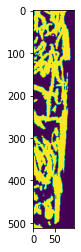

In [57]:
plt.imshow(np.max(truth[0,0:100],axis=0))

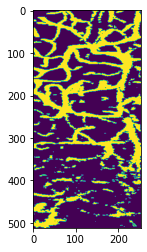

In [58]:
plt.imshow(np.max(seg[0,0:100],axis=0))

In [59]:
(np.array(truth.shape)/np.array(seg.shape))[1:]
sp.ndimage.zoom(truth, 1/(np.array(truth.shape)/np.array(seg.shape)), order=0).shape

(1, 512, 512, 253)

In [127]:
seg.shape

(1, 512, 512, 311)

In [128]:
if truth.shape != seg.shape:
    truth = sp.ndimage.zoom(truth, 1/(np.array(truth.shape)/np.array(seg.shape)), order=0)

# UNETR Ensembale

In [60]:
unetrEnsemble = pd.DataFrame()

In [65]:
unetrEnsemble

,Image,Dice,Precision,Recall,Hausdorff95,meanSurfaceDistance
0,../FILES_FOR_SHRUTI/C57/01/C1-XYZres438_Simple...,0.533599,0.542753,0.524750,35.283037,7.446918
1,../FILES_FOR_SHRUTI/C57/02/C1-XYZres445_0001_S...,0.414228,0.346317,0.515272,110.512406,8.643282
2,../FILES_FOR_SHRUTI/C57/03/C1-XYZres460_0001_S...,0.275941,0.161548,0.945350,106.347187,3.117818
3,../FILES_FOR_SHRUTI/C57/01/C1-XYZres438_Simple...,0.533801,0.542753,0.525141,29.267225,6.743928
4,../FILES_FOR_SHRUTI/C57/02/C1-XYZres445_0001_S...,0.414340,0.346194,0.515889,133.537945,5.928667
5,../FILES_FOR_SHRUTI/C57/03/C1-XYZres460_0001_S...,0.274935,0.160799,0.947405,139.431874,1.624676


In [64]:
for x in tqdm(gt_images):
    truth = io.imread(x)
    #truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    #truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = remove_small_comps_3d(truth)
    truth = np.expand_dims(truth,0)
    truth = np.swapaxes(truth, 1,3)
    _mean = np.load(re.sub('_Simple Segmentation2.tiff','_up_reshape_meante.npy',x))
    seg = np.zeros(_mean.shape[1:])
    seg[(_mean[1,:,:,:] > min_prob)] = 1
    seg[(_mean[2,:,:,:] > min_prob)] = 2
    seg[seg!=1]=0
    seg[seg==1]=1
    seg = remove_small_comps_3d(seg)
    seg = np.expand_dims(seg,0)
    #seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    if truth.shape != seg.shape:
        truth = sp.ndimage.zoom(truth, 1/(np.array(truth.shape)/np.array(seg.shape)), order=0)
    truth = binary_erosion(binary_erosion(truth))
    #print(compute_hausdorff_distance(truth,seg,percentile=95))
    #print(compute_average_surface_distance(truth,seg))
    new_row = {'Image':re.sub('_Simple Segmentation.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
               #}
    unetrEnsemble = unetrEnsemble.append(new_row,ignore_index=True)
print(unetrEnsemble)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_4184204/866319708.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unetrEnsemble = unetrEnsemble.append(new_row,ignore_index=True)
 33%|███▎      | 1/3 [01:17<02:35, 77.56s/it]/tmp/ipykernel_4184204/866319708.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unetrEnsemble = unetrEnsemble.append(new_row,ignore_index=True)
 67%|██████▋   | 2/3 [02:34<01:17, 77.02s/it]/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 340 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:

                                               Image      Dice  Precision  \
0  ../FILES_FOR_SHRUTI/C57/01/C1-XYZres438_Simple...  0.533599   0.542753   
1  ../FILES_FOR_SHRUTI/C57/02/C1-XYZres445_0001_S...  0.414228   0.346317   
2  ../FILES_FOR_SHRUTI/C57/03/C1-XYZres460_0001_S...  0.275941   0.161548   
3  ../FILES_FOR_SHRUTI/C57/01/C1-XYZres438_Simple...  0.533801   0.542753   
4  ../FILES_FOR_SHRUTI/C57/02/C1-XYZres445_0001_S...  0.414340   0.346194   
5  ../FILES_FOR_SHRUTI/C57/03/C1-XYZres460_0001_S...  0.274935   0.160799   

     Recall  Hausdorff95  meanSurfaceDistance  
0  0.524750    35.283037             7.446918  
1  0.515272   110.512406             8.643282  
2  0.945350   106.347187             3.117818  
3  0.525141    29.267225             6.743928  
4  0.515889   133.537945             5.928667  
5  0.947405   139.431874             1.624676  


In [60]:
print(np.mean(unetrEnsemble['Dice']))
print(np.std(unetrEnsemble['Dice']))

0.5892216684916478
0.0


In [50]:
re.sub('_Simple Segmentation.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)).split('/')

'64'

In [15]:
#print(unetrEnsemble)

## UNETR Single

In [16]:
unetrSingle = pd.DataFrame()

In [17]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    path = Path('matt_preds')
    _files = list(path.glob(re.sub('_Simple Segmentation_sub1.tiff','_mean_1x.npy',re.sub('../TBI/GT_filtered\+raw/','*',x))))
    if os.path.exists(_files[0].as_posix()):
        _mean = np.load(_files[0].as_posix())
        print('yes')
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[2:])
    seg[(_mean[0,1,:,:,:] > min_prob)] = 1
    seg[(_mean[0,2,:,:,:] > min_prob)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetrSingle = unetrSingle.append(new_row,ignore_index=True)
print(unetrSingle)

  0%|          | 0/9 [00:00<?, ?it/s]

yes


 11%|█         | 1/9 [01:51<14:50, 111.34s/it]

yes


 22%|██▏       | 2/9 [03:38<12:43, 109.04s/it]

yes


 33%|███▎      | 3/9 [05:29<10:58, 109.74s/it]

yes


 44%|████▍     | 4/9 [07:19<09:09, 109.97s/it]

yes


 56%|█████▌    | 5/9 [09:05<07:14, 108.50s/it]

yes


 67%|██████▋   | 6/9 [10:55<05:27, 109.01s/it]

yes


 78%|███████▊  | 7/9 [12:40<03:35, 107.82s/it]

yes


 89%|████████▉ | 8/9 [14:29<01:47, 107.94s/it]

yes


100%|██████████| 9/9 [16:15<00:00, 108.43s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.732965   0.934816  0.602804     4.472136   
1    XYZres95_0001  0.539186   0.921358  0.381106    53.009433   
2        XYZres032  0.908900   0.893595  0.924739     2.000000   
3        XYZres025  0.799614   0.907732  0.714510     2.449490   
4   XYZres114_0001  0.782885   0.840949  0.732321    23.086793   
5        XYZres008  0.857850   0.793963  0.932919     3.000000   
6        XYZres115  0.712198   0.724948  0.699888    23.622024   
7   XYZres204_0001  0.804725   0.720418  0.911379    20.124612   
8   XYZres214_0001  0.834524   0.811270  0.859150     2.000000   

   meanSurfaceDistance  
0             1.330380  
1             7.238751  
2             0.659656  
3             0.802545  
4             1.909906  
5             0.717940  
6             4.064531  
7             1.167560  
8             0.615520  


# unet Ensemble

In [23]:
unetEnsemble = pd.DataFrame()

In [24]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        _mean = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        _std = pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_std.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        print('yes')
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[1:])
    seg[(_mean[1,:,:,:] > min_prob) * (_std[1,:,:,:] < max_var)] = 1
    seg[(_mean[2,:,:,:] > min_prob) * (_std[2,:,:,:] < max_var)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    #break
    #print(compute_hausdorff_distance(truth,seg,percentile=95))
    #print(compute_average_surface_distance(truth,seg))
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetEnsemble = unetEnsemble.append(new_row,ignore_index=True)
print(unetEnsemble)

  0%|          | 0/9 [00:00<?, ?it/s]

yes


 11%|█         | 1/9 [01:48<14:30, 108.86s/it]

yes


 22%|██▏       | 2/9 [03:35<12:34, 107.80s/it]

yes


 33%|███▎      | 3/9 [05:18<10:32, 105.47s/it]

yes


 44%|████▍     | 4/9 [07:09<08:58, 107.76s/it]

yes


 56%|█████▌    | 5/9 [08:54<07:07, 106.81s/it]

yes


 67%|██████▋   | 6/9 [10:43<05:22, 107.34s/it]

yes


 78%|███████▊  | 7/9 [12:34<03:37, 108.70s/it]

yes


 89%|████████▉ | 8/9 [14:19<01:47, 107.46s/it]

yes


100%|██████████| 9/9 [16:04<00:00, 107.19s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.801307   0.732036  0.885059     5.099020   
1    XYZres95_0001  0.813064   0.907671  0.736317     2.828427   
2        XYZres032  0.740794   0.656121  0.850560    22.649503   
3        XYZres025  0.767427   0.654141  0.928171    17.029386   
4   XYZres114_0001  0.726145   0.629170  0.858461    27.676705   
5        XYZres008  0.758125   0.656939  0.896159    15.394804   
6        XYZres115  0.820671   0.743303  0.916016     2.000000   
7   XYZres204_0001  0.685665   0.602459  0.795537    76.065761   
8   XYZres214_0001  0.777551   0.699731  0.874845    14.317821   

   meanSurfaceDistance  
0             0.698951  
1             1.096994  
2             1.306007  
3             0.615645  
4             3.353060  
5             0.813013  
6             0.638872  
7            12.550634  
8             0.612136  


# unet Single

In [20]:
unetSingle = pd.DataFrame()

In [21]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_mean_1x.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        _mean = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean_1x.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        print('yes')
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[1:])
    seg[(_mean[1,:,:,:] > min_prob)] = 1
    seg[(_mean[2,:,:,:] > min_prob)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetSingle = unetSingle.append(new_row,ignore_index=True)
print(unetSingle)

  0%|          | 0/9 [00:00<?, ?it/s]

yes


 11%|█         | 1/9 [01:51<14:54, 111.84s/it]

yes


 22%|██▏       | 2/9 [03:42<12:57, 111.06s/it]

yes


 33%|███▎      | 3/9 [05:34<11:08, 111.44s/it]

yes


 44%|████▍     | 4/9 [07:25<09:16, 111.24s/it]

yes


 56%|█████▌    | 5/9 [09:11<07:17, 109.43s/it]

yes


 67%|██████▋   | 6/9 [11:02<05:29, 109.98s/it]

yes


 78%|███████▊  | 7/9 [12:47<03:36, 108.39s/it]

yes


 89%|████████▉ | 8/9 [14:35<01:48, 108.37s/it]

yes


100%|██████████| 9/9 [16:22<00:00, 109.13s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.778844   0.903704  0.684297     3.741657   
1    XYZres95_0001  0.587557   0.898510  0.436496    33.526109   
2        XYZres032  0.901414   0.864269  0.941896     2.000000   
3        XYZres025  0.800132   0.876116  0.736276     2.449490   
4   XYZres114_0001  0.814414   0.858140  0.774928    19.646883   
5        XYZres008  0.844070   0.754711  0.957431     3.605551   
6        XYZres115  0.728314   0.729271  0.727360    25.942244   
7   XYZres204_0001  0.810156   0.731818  0.907275    15.556349   
8   XYZres214_0001  0.828708   0.761698  0.908647     2.236068   

   meanSurfaceDistance  
0             1.110713  
1             4.870977  
2             0.631022  
3             0.804696  
4             1.625758  
5             0.725862  
6             4.250991  
7             1.144086  
8             0.602750  


# Ilastik

In [25]:
ilastik = pd.DataFrame()

In [26]:
for x in tqdm(test_file):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_Simple Segmentation.h5',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        hf = h5py.File(re.sub('_Simple Segmentation_sub1.tiff','_Simple Segmentation.h5',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)),'r')
        seg = np.array(hf.get('exported_data')) - 1
        if len(seg.shape) != 5:
            seg = np.expand_dims(seg,4)
            seg = np.swapaxes(seg,0,4)
        else:
            seg = np.swapaxes(seg,1,4)
        seg = sp.ndimage.zoom(seg,(1,1,507/512,507/512,252/96),order=0)
        seg = np.swapaxes(seg,2,3)
    else:
        print(x)
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = seg.astype(np.float32)
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    ilastik = ilastik.append(new_row,ignore_index=True)
print(ilastik)

100%|██████████| 9/9 [15:44<00:00, 104.95s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.775189   0.672537  0.914822     3.162278   
1    XYZres95_0001  0.578557   0.542236  0.620093    38.118237   
2        XYZres032  0.339393   0.204729  0.991707    50.457903   
3        XYZres025  0.773638   0.654568  0.945659     3.000000   
4   XYZres114_0001  0.279218   0.162792  0.980347    46.400431   
5        XYZres008  0.429188   0.274612  0.981869    70.724819   
6        XYZres115  0.561378   0.480484  0.675025    25.787594   
7   XYZres204_0001  0.267876   0.155582  0.962758    52.430907   
8   XYZres214_0001  0.380767   0.766170  0.253334    78.915461   

   meanSurfaceDistance  
0             0.802238  
1             6.467795  
2             0.862269  
3             0.624250  
4             1.540907  
5             0.629770  
6             4.613277  
7             1.335430  
8            23.170078  


# Make Plot

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


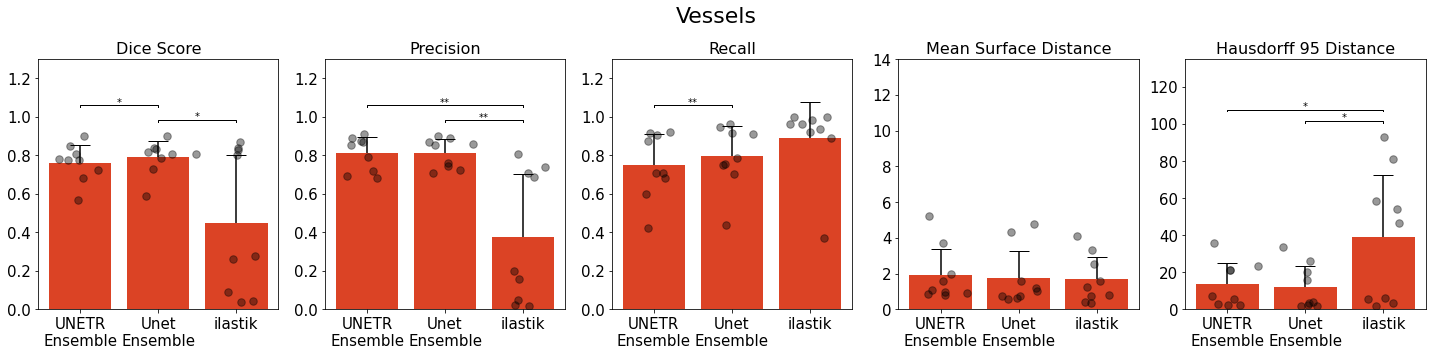

In [32]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
labels = ['UNETR\nEnsemble', 'Unet\nEnsemble', 'ilastik']
res = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]

data = [np.mean(x['Dice']) for x in data_frames]
data_sd = [np.std(x['Dice']) for x in data_frames]
#data_sd = np.array([np.zeros(len(data_sd)),data_sd])
axs[0].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[0].set_title('Dice Score', fontsize=16)
df_dice = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Dice']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_dice[labels[i]] = y
    axs[0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_dice = []
for i,j in res:
    pvals_dice.append(stats.wilcoxon(df_dice[i], df_dice[j],alternative='two-sided',method='exact').pvalue)
#print(pvals_dice)
#pvals_dice = multipletests(pvals_dice, method = 'hs')[1]
#print(pvals_dice)
res_dice_signif_comb = []
res_dice_signif = []
for idx, val in enumerate(pvals_dice):
    if val < 0.05:
        res_dice_signif_comb.append(res[idx])
        res_dice_signif.append(val)
y_range=0.5
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'UNETR\nSingle' not in x]
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_dice_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]
    # What level is this bar among the bars above the plot?
    level = len(res_dice_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top + 0.01
    bar_tips = bar_height - (y_range * 0.02)
    axs[0].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_dice_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (1.2 * 0.01)
    axs[0].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[0].set_ylim(0,1.3)
    
data = [np.mean(x['Precision']) for x in data_frames]
data_sd = [np.std(x['Precision']) for x in data_frames]
axs[1].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[1].set_title('Precision', fontsize=16)
df_precision = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Precision']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.15, size=len(y))
    df_precision[labels[i]] = y
    axs[1].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_precision = []
for i,j in res:
    pvals_precision.append(stats.wilcoxon(df_precision[i], df_precision[j],alternative='two-sided',method='exact').pvalue)
#pvals_precision = multipletests(pvals_precision, method = 'bonferroni')[1]
res_precision_signif_comb = []
res_precision_signif = []
for idx, val in enumerate(pvals_precision):
    if val < 0.05:
        res_precision_signif_comb.append(res[idx])
        res_precision_signif.append(val)
y_range=0.5
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'UNETR\nSingle' not in x]
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_precision_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_precision_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[1].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_precision_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (1.4 * 0.01)
    axs[1].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[1].set_ylim(0,1.3)

data = [np.mean(x['Recall']) for x in data_frames]
data_sd = [np.std(x['Recall']) for x in data_frames]
axs[2].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[2].set_title('Recall', fontsize=16)
df_recall = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Recall']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_recall[labels[i]] = y
    axs[2].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_recall = []
for i,j in res:
    pvals_recall.append(stats.wilcoxon(df_recall[i], df_recall[j],alternative='two-sided',method='exact').pvalue)
#pvals_recall = multipletests(pvals_recall, method = 'bonferroni')[1]
res_recall_signif_comb = []
res_recall_signif = []
for idx, val in enumerate(pvals_recall):
    if val < 0.05:
        res_recall_signif_comb.append(res[idx])
        res_recall_signif.append(val)
y_range=0.5
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'UNETR\nSingle' not in x]
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_recall_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_recall_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[2].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_recall_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (1.2 * 0.01)
    axs[2].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[2].set_ylim(0,1.3)

    
data = [np.mean(x['meanSurfaceDistance']) for x in data_frames]
data_sd = [np.std(x['meanSurfaceDistance']) for x in data_frames]
axs[3].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[3].set_title('Mean Surface Distance', fontsize=16)
df_msd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['meanSurfaceDistance']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_msd[labels[i]] = y
    axs[3].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_msd = []
for i,j in res:
    pvals_msd.append(stats.wilcoxon(df_msd[i], df_msd[j],alternative='two-sided',method='exact').pvalue)
#pvals_msd = multipletests(pvals_msd, method = 'bonferroni')[1]
res_msd_signif_comb = []
res_msd_signif = []
for idx, val in enumerate(pvals_msd):
    if val < 0.05:
        res_msd_signif_comb.append(res[idx])
        res_msd_signif.append(val)
y_range=0.5
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'UNETR\nSingle' not in x]
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_msd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_msd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[3].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_msd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (8 * 0.01)
    axs[3].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[3].set_ylim(0,14)


#data = [np.mean(x['Hausdorff']) for x in data_frames]
#data_sd = [np.std(x['Hausdorff']) for x in data_frames]
#axs[1,0].bar(labels,data,yerr=data_sd)
#axs[1,0].set_title('Hausdorff Distance')
#for i, df in enumerate(data_frames):
#    y = df['Hausdorff']
#    x = np.random.normal(i, 0.13, size=len(y))
#    axs[1,0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
#axs[1,0].set_ylim(0,200)

data = [np.mean(x['Hausdorff95']) for x in data_frames]
data_sd = [np.std(x['Hausdorff95']) for x in data_frames]
axs[4].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[4].set_title('Hausdorff 95 Distance', fontsize=16)
df_hd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Hausdorff95']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_hd[labels[i]] = y
    axs[4].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_hd = []
for i,j in res:
    pvals_hd.append(stats.wilcoxon(df_hd[i], df_hd[j],alternative='two-sided',method='exact').pvalue)
#pvals_hd = multipletests(pvals_hd, method = 'bonferroni')[1]
res_hd_signif_comb = []
res_hd_signif = []
for idx, val in enumerate(pvals_hd):
    if val < 0.05:
        res_hd_signif_comb.append(res[idx])
        res_hd_signif.append(val)
y_range=0.5
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'UNETR\nSingle' not in x]
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_hd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_hd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * 100 * level) + top + 3
    bar_tips = bar_height - (y_range * 0.02*100)
    axs[4].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_hd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (120 * 0.01)
    axs[4].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[4].set_ylim(0,135)
for i in range(5):
    axs[i].tick_params(axis='x', labelsize=15)
    axs[i].tick_params(axis='y', labelsize=15)

fig.suptitle('Vessels',fontsize=22)
fig.tight_layout()
fig.savefig('model_eval_vessels.png')

In [18]:
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
for data_frame in data_frames:
    print(data_frame.mean())
    print(data_frame.std())

Dice                    0.763067
Precision               0.810597
Recall                  0.749663
Hausdorff95            13.566886
meanSurfaceDistance     1.900258
dtype: float64
Dice                    0.096480
Precision               0.089459
Recall                  0.172148
Hausdorff95            12.131861
meanSurfaceDistance     1.544835
dtype: float64
Dice                    0.790461
Precision               0.812733
Recall                  0.796693
Hausdorff95            12.115827
meanSurfaceDistance     1.737011
dtype: float64
Dice                    0.087669
Precision               0.076224
Recall                  0.164648
Hausdorff95            12.143726
meanSurfaceDistance     1.622192
dtype: float64
Dice                    0.449273
Precision               0.376803
Recall                  0.892950
Hausdorff95            38.921016
meanSurfaceDistance     1.674862
dtype: float64
Dice                    0.374646
Precision               0.346835
Recall                  0.198366
H

/tmp/ipykernel_3927521/601560446.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.mean())
/tmp/ipykernel_3927521/601560446.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.std())


In [27]:
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
for data_frame in data_frames:
    print(data_frame.mean())
    print(data_frame.std())

Dice                    0.711937
Precision               0.628137
Recall                  0.841482
Hausdorff95            23.654228
meanSurfaceDistance     1.248422
dtype: float64
Dice                    0.062230
Precision               0.110553
Recall                  0.053174
Hausdorff95            19.298793
meanSurfaceDistance     0.569302
dtype: float64
Dice                    0.765639
Precision               0.697952
Recall                  0.860125
Hausdorff95            20.340159
meanSurfaceDistance     2.409479
dtype: float64
Dice                    0.043767
Precision               0.091108
Recall                  0.060709
Hausdorff95            22.670194
meanSurfaceDistance     3.900826
dtype: float64
Dice                    0.487245
Precision               0.434857
Recall                  0.813957
Hausdorff95            40.999737
meanSurfaceDistance     4.449557
dtype: float64
Dice                    0.195810
Precision               0.239478
Recall                  0.252071
H

/tmp/ipykernel_3927521/601560446.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.mean())
/tmp/ipykernel_3927521/601560446.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.std())


In [40]:
res

[('UNETR\nEnsemble', 'Unet\nEnsemble'),
 ('UNETR\nEnsemble', 'ilastik'),
 ('Unet\nEnsemble', 'ilastik')]

In [52]:
print(np.mean(data_frames[0]))
print(np.std(data_frames[0]))
print(np.mean(data_frames[1]))
print(np.std(data_frames[1]))
print(np.mean(data_frames[2]))
print(np.std(data_frames[2]))

Dice                    0.763067
Precision               0.810597
Recall                  0.749663
Hausdorff95            13.566886
meanSurfaceDistance     1.900258
dtype: float64
Dice                    0.090962
Precision               0.084343
Recall                  0.162302
Hausdorff95            11.438028
meanSurfaceDistance     1.456484
dtype: float64
Dice                    0.790461
Precision               0.812733
Recall                  0.796693
Hausdorff95            12.115827
meanSurfaceDistance     1.737011
dtype: float64
Dice                    0.082655
Precision               0.071865
Recall                  0.155232
Hausdorff95            11.449215
meanSurfaceDistance     1.529417
dtype: float64
Dice                    0.449273
Precision               0.376803
Recall                  0.892950
Hausdorff95            38.921016
meanSurfaceDistance     1.674862
dtype: float64
Dice                    0.353220
Precision               0.326999
Recall                  0.187021
H

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Image,Dice,Precision,Recall,Hausdorff95,meanSurfaceDistance
0,XYZres013_0001,0.789158,0.899734,0.702787,3.316625,1.045425
1,XYZres95_0001,0.590400,0.892749,0.441034,33.541020,4.770031
2,XYZres032,0.900587,0.857947,0.947689,2.000000,0.632745
3,XYZres025,0.807703,0.870910,0.753049,2.236068,0.765610
4,XYZres114_0001,0.818571,0.851970,0.787691,20.047442,1.603041
5,XYZres008,0.838657,0.743491,0.961763,4.000000,0.752342
6,XYZres115,0.728616,0.708959,0.749393,26.248809,4.303545
7,XYZres204_0001,0.807481,0.726471,0.908827,15.652476,1.170527
8,XYZres214_0001,0.832978,0.762370,0.918000,2.000000,0.589837


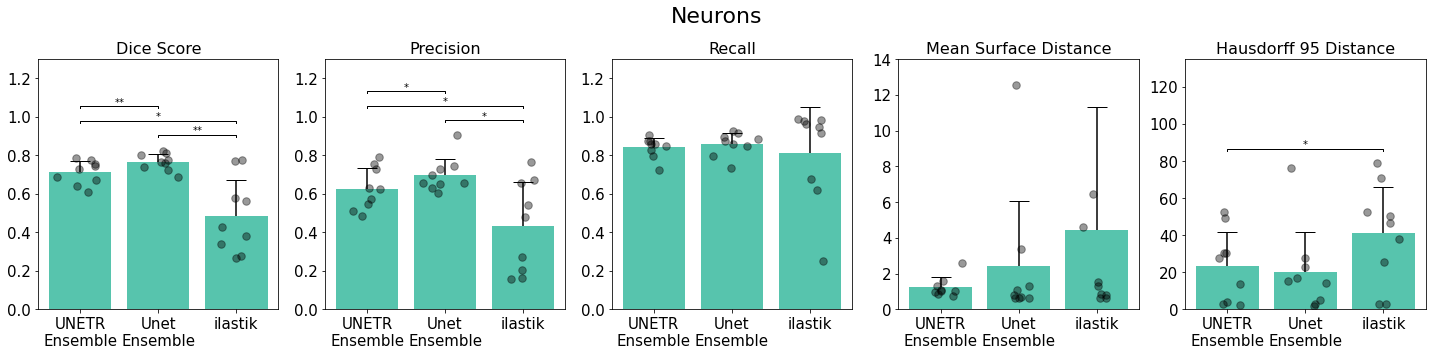

In [62]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
labels = ['UNETR\nEnsemble', 'Unet\nEnsemble', 'ilastik']
res = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]

data = [np.mean(x['Dice']) for x in data_frames]
data_sd = [np.std(x['Dice']) for x in data_frames]
#data_sd = np.array([np.zeros(len(data_sd)),data_sd])
axs[0].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[0].set_title('Dice Score', fontsize=16)
df_dice = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Dice']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_dice[labels[i]] = y
    axs[0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_dice = []
for i,j in res:
    pvals_dice.append(stats.wilcoxon(df_dice[i], df_dice[j],alternative='two-sided',method='exact').pvalue)
#print(pvals_dice)
#pvals_dice = multipletests(pvals_dice, method = 'hs')[1]
#print(pvals_dice)
res_dice_signif_comb = []
res_dice_signif = []
for idx, val in enumerate(pvals_dice):
    if val < 0.05:
        res_dice_signif_comb.append(res[idx])
        res_dice_signif.append(val)
y_range=0.5
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'UNETR\nSingle' not in x]
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_dice_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_dice_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top + 0.01
    bar_tips = bar_height - (y_range * 0.02)
    axs[0].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_dice_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[0].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[0].set_ylim(0,1.3)
    
data = [np.mean(x['Precision']) for x in data_frames]
data_sd = [np.std(x['Precision']) for x in data_frames]
axs[1].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[1].set_title('Precision', fontsize=16)
df_precision = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Precision']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.15, size=len(y))
    df_precision[labels[i]] = y
    axs[1].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_precision = []
for i,j in res:
    pvals_precision.append(stats.wilcoxon(df_precision[i], df_precision[j],alternative='two-sided',method='exact').pvalue)
#pvals_precision = multipletests(pvals_precision, method = 'bonferroni')[1]
res_precision_signif_comb = []
res_precision_signif = []
for idx, val in enumerate(pvals_precision):
    if val < 0.05:
        res_precision_signif_comb.append(res[idx])
        res_precision_signif.append(val)
y_range=0.5
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'UNETR\nSingle' not in x]
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_precision_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_precision_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[1].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_precision_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[1].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[1].set_ylim(0,1.3)

data = [np.mean(x['Recall']) for x in data_frames]
data_sd = [np.std(x['Recall']) for x in data_frames]
axs[2].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[2].set_title('Recall', fontsize=16)
df_recall = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Recall']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_recall[labels[i]] = y
    axs[2].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_recall = []
for i,j in res:
    pvals_recall.append(stats.wilcoxon(df_recall[i], df_recall[j],alternative='two-sided',method='exact').pvalue)
#pvals_recall = multipletests(pvals_recall, method = 'bonferroni')[1]
res_recall_signif_comb = []
res_recall_signif = []
for idx, val in enumerate(pvals_recall):
    if val < 0.05:
        res_recall_signif_comb.append(res[idx])
        res_recall_signif.append(val)
y_range=0.5
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'UNETR\nSingle' not in x]
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_recall_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_recall_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[2].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_recall_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[2].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[2].set_ylim(0,1.3)
for i in range(5):
    axs[i].tick_params(axis='x', labelsize=15)
    axs[i].tick_params(axis='y', labelsize=15)
    
data = [np.mean(x['meanSurfaceDistance']) for x in data_frames]
data_sd = [np.std(x['meanSurfaceDistance']) for x in data_frames]
axs[3].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[3].set_title('Mean Surface Distance', fontsize=16)
df_msd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['meanSurfaceDistance']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_msd[labels[i]] = y
    axs[3].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_msd = []
for i,j in res:
    pvals_msd.append(stats.wilcoxon(df_msd[i], df_msd[j],alternative='two-sided',method='exact').pvalue)
#pvals_msd = multipletests(pvals_msd, method = 'bonferroni')[1]
res_msd_signif_comb = []
res_msd_signif = []
for idx, val in enumerate(pvals_msd):
    if val < 0.05:
        res_msd_signif_comb.append(res[idx])
        res_msd_signif.append(val)
y_range=0.5
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'UNETR\nSingle' not in x]
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_msd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_msd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[3].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_msd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[3].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[3].set_ylim(0,14)


#data = [np.mean(x['Hausdorff']) for x in data_frames]
#data_sd = [np.std(x['Hausdorff']) for x in data_frames]
#axs[1,0].bar(labels,data,yerr=data_sd)
#axs[1,0].set_title('Hausdorff Distance')
#for i, df in enumerate(data_frames):
#    y = df['Hausdorff']
#    x = np.random.normal(i, 0.13, size=len(y))
#    axs[1,0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
#axs[1,0].set_ylim(0,200)

data = [np.mean(x['Hausdorff95']) for x in data_frames]
data_sd = [np.std(x['Hausdorff95']) for x in data_frames]
axs[4].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[4].set_title('Hausdorff 95 Distance', fontsize=16)
df_hd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Hausdorff95']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_hd[labels[i]] = y
    axs[4].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_hd = []
for i,j in res:
    pvals_hd.append(stats.wilcoxon(df_hd[i], df_hd[j],alternative='two-sided',method='exact').pvalue)
#pvals_hd = multipletests(pvals_hd, method = 'bonferroni')[1]
res_hd_signif_comb = []
res_hd_signif = []
for idx, val in enumerate(pvals_hd):
    if val < 0.05:
        res_hd_signif_comb.append(res[idx])
        res_hd_signif.append(val)
y_range=0.5
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'UNETR\nSingle' not in x]
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_hd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_hd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * 75 * level) + top + 3
    bar_tips = bar_height - (y_range * 0.02*75)
    axs[4].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_hd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[4].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[4].set_ylim(0,135)

fig.suptitle('Neurons',fontsize=22)
fig.tight_layout()
fig.savefig('model_eval_neurons.png')

In [63]:
pvals_msd

[0.65234375, 0.49609375, 0.8203125]

In [64]:
pvals_hd

[0.734375, 0.0390625, 0.07421875]

In [61]:
res

[('UNETR\nEnsemble', 'Unet\nEnsemble'),
 ('UNETR\nEnsemble', 'ilastik'),
 ('Unet\nEnsemble', 'ilastik')]

In [77]:
df_dice
res = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]
pvals_dice = []
for i,j in res:
    pvals_dice.append(stats.wilcoxon(df_dice[i], df_dice[j]).pvalue)
pvals_dice = multipletests(pvals_dice, method = 'bonferroni')[1]
res_dice_signif = []
for idx, val in enumerate(pvals_dice):
    if val < 0.05:
        res_dice_signif.append(res[idx])
res_dice_signif

[('UNETR\nEnsemble', 'Unet\nSingle'),
 ('UNETR\nSingle', 'ilastik'),
 ('Unet\nSingle', 'ilastik')]

In [41]:
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')


[('UNETR\nEnsemble', 'UNETR\nSingle'),
 ('UNETR\nEnsemble', 'Unet\nEnsemble'),
 ('UNETR\nEnsemble', 'Unet\nSingle'),
 ('UNETR\nEnsemble', 'ilastik'),
 ('UNETR\nSingle', 'Unet\nEnsemble'),
 ('UNETR\nSingle', 'Unet\nSingle'),
 ('UNETR\nSingle', 'ilastik'),
 ('Unet\nEnsemble', 'Unet\nSingle'),
 ('Unet\nEnsemble', 'ilastik'),
 ('Unet\nSingle', 'ilastik')]

In [57]:
pvals[1]

array([0.078125 , 0.078125 , 0.0390625, 0.1171875, 1.       , 1.       ,
       0.0390625, 1.       , 0.078125 , 0.0390625])